<a href="https://colab.research.google.com/github/EZ6990/DeepLearning/blob/master/KaggleHomeDepot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle
import json
token = {"username":"bgudltaldanny","key":"65b62f1a36c14c834b4e88037463a4f8"}
with open('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=8d7bcf364a8f58eaa932d8901ad6049a9b939044acdd3b7efea6292bf682c81b
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [3]:
!kaggle competitions download -c home-depot-product-search-relevance
!touch ~/.kaggle/kaggle.json
!ls -la ~/.kaggle/kaggle.json
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
-rw-r--r-- 1 root root 0 Feb 10 10:13 /root/.kaggle/kaggle.json


In [4]:
!wget https://storage.googleapis.com/kaggle-forum-message-attachments/117897/4154/solution.csv -P home-depot-product-search-relevance/

--2020-02-10 10:13:57--  https://storage.googleapis.com/kaggle-forum-message-attachments/117897/4154/solution.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3301351 (3.1M) [text/csv]
Saving to: ‘home-depot-product-search-relevance/solution.csv’

solution.csv        100%[===================>]   3.15M  --.-KB/s    in 0.02s   

2020-02-10 10:13:57 (184 MB/s) - ‘home-depot-product-search-relevance/solution.csv’ saved [3301351/3301351]



In [5]:
!kaggle competitions download -c home-depot-product-search-relevance
!unzip home-depot-product-search-relevance.zip -d home-depot-product-search-relevance/
!unzip home-depot-product-search-relevance/train.csv.zip -d home-depot-product-search-relevance/
!unzip home-depot-product-search-relevance/test.csv.zip -d home-depot-product-search-relevance/

 95% 66.0M/69.4M [00:00<00:00, 63.4MB/s]
100% 69.4M/69.4M [00:00<00:00, 134MB/s] 
Archive:  home-depot-product-search-relevance.zip
  inflating: home-depot-product-search-relevance/attributes.csv.zip  
  inflating: home-depot-product-search-relevance/product_descriptions.csv.zip  
  inflating: home-depot-product-search-relevance/relevance_instructions.docx  
  inflating: home-depot-product-search-relevance/sample_submission.csv.zip  
  inflating: home-depot-product-search-relevance/test.csv.zip  
  inflating: home-depot-product-search-relevance/train.csv.zip  
Archive:  home-depot-product-search-relevance/train.csv.zip
  inflating: home-depot-product-search-relevance/train.csv  
Archive:  home-depot-product-search-relevance/test.csv.zip
  inflating: home-depot-product-search-relevance/test.csv  


In [0]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout,Conv1D, MaxPool1D,Concatenate, LSTM, Reshape, CuDNNLSTM, Embedding, BatchNormalization,Activation
from keras.optimizers import RMSprop
import keras.backend as K
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.preprocessing import FunctionTransformer,KBinsDiscretizer,OneHotEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict,cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from keras.regularizers import l2
from scipy import spatial
import xgboost as xgb
import matplotlib.pyplot as plt


In [0]:
path='./home-depot-product-search-relevance'
train=pd.read_csv(path+'/train.csv',encoding="Latin-1")
test_data=pd.read_csv(path+'/test.csv',encoding="Latin-1")
test_solution=pd.read_csv(path+'/solution.csv',encoding="Latin-1")
test=pd.merge(test_data, test_solution,on='id')
test=test[test['Usage'] != 'Ignored']

In [18]:
train.head()
train['norm_relevance'] = (train['relevance'] - 1) / 2
train.head()

,id,product_uid,product_title,search_term,relevance,norm_relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,1.000
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,0.750
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,1.000
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,0.665
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,0.835


In [0]:
max_product_title_len=train.product_title.map(lambda x: len(x)).max()
max_search_term=train.search_term.map(lambda x: len(x)).max()
max_input_len=max(max_product_title_len,max_search_term)

In [0]:
class MyCharGenerator(Sequence):
  def __init__(self,padding,df,batch_size=32,char_value=0):
    self.padding=padding
    self.char_value=char_value
    self.df=df
    self.batch_size=batch_size


  def __iter__(self):
    while(True):
      X1 = []
      X2 = []
      y = []

      for index,row in self.df.iterrows():
        y.append(row['norm_relevance'])
        st_list= [ord(c) for c in list(row['search_term'])]
        pt_list=[ord(c) for c in list(row['product_title'])]
        #X1.append(np.pad(st_list,(0,self.padding-len(st_list))))
        #X2.append(np.pad(pt_list,(0,self.padding-len(pt_list))))
        X1.append(np.reshape(np.pad(st_list,(0,self.padding-len(st_list))),(147,1)))
        X2.append(np.reshape(np.pad(pt_list,(0,self.padding-len(pt_list))),(147,1)))
        # assume there's one document per line, tokens separated by whitespace
        if (index + 1) % self.batch_size == 0:
          y=np.array(y)

          yield (np.array([X1,X2]),y)
          X1 = []
          X2 = []
          y=[]

      y=np.array(y)
      if(len(y) > 0):
        yield np.array([X1,X2]),y


In [0]:
class MyWordGenerator(Sequence):
  def __init__(self,padding,df,batch_size=32,char_value=0):
    self.padding=padding
    self.df=df
    self.batch_size=batch_size
    self.words_dictonary = {}


  def __iter__(self):
    while(True):
      X1 = []
      X2 = []
      y = []

      for index,row in self.df.iterrows():
        y.append(row['norm_relevance'])
        st_list = []
        for word in row['search_term'].split(' '):
          if not (word in self.words_dictonary):
            self.words_dictonary[word] = len(self.words_dictonary)
          st_list.append(self.words_dictonary[word])
            
        pt_list = []
        for word in row['product_title'].split(' '):
          if not (word in self.words_dictonary):
            self.words_dictonary[word] = len(self.words_dictonary)
          pt_list.append(self.words_dictonary[word])

        X1.append(np.reshape(np.pad(st_list,(0,self.padding-len(st_list))),(self.padding,1)))
        X2.append(np.reshape(np.pad(pt_list,(0,self.padding-len(pt_list))),(self.padding,1)))
        # assume there's one document per line, tokens separated by whitespace
        if (index + 1) % self.batch_size == 0:
          y=np.array(y)

          yield (np.array([X1,X2]),y)
          X1 = []
          X2 = []
          y=[]

      y=np.array(y)
      if(len(y) > 0):
        yield np.array([X1,X2]),y


def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def our_mse(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true), axis=-1)

loss_index = 0
def new_loss(y_actual,y_predicted):
  global loss_index
  global y_train
  global X1_train
  global X2_train

  cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
  loss = tf.constant(0.0)
  m = tf.constant(-0.00015)
  x = tf.constant(0.0)
  K.switch(tf.constant(y_train[x]))
  loss = tf.add(loss,tf.subtract(tf.constant(1.0),
                                  cosine_loss(np.float32(X1_train[loss_index+i]),np.float32(X2_train[loss_index+i]))))
  loss_index+=32
  with open('log.log', 'a') as file:
    json.dump(loss_index, file)
  tf.Print(loss,[loss],("%s" %loss_index))
  #return tf.add(K.sum(tf.multiply(tf.constant(0.0),y_predicted)),loss)
  return cosine_loss(y_actual,y_predicted)

# siames_model=network(max_input_len)
# siames_model.summary()
# siames_model.compile(loss=new_loss ,optimizer='adam',metrics=['mae','accuracy'])
# model_hist = siames_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=3,batch_size=32,validation_data=([X1_test,X2_test],y_test))


## Siamese network from the article

In [0]:
def network(n_fetures,n_described=1):
  inp=Input(shape=(n_fetures,n_described))
  x = CuDNNLSTM(n_fetures)(inp)
  x = Reshape((n_fetures,1))(x)
  x=Conv1D(filters=32,kernel_size=10,activation='relu')(x)
  x=MaxPool1D()(x)
  x=Conv1D(filters=64,kernel_size=10,activation='relu')(x)
  x=MaxPool1D()(x)
  x=Conv1D(filters=128,kernel_size=10,activation='relu')(x)
  x=Flatten()(x)
  x=Dense(128,activation='relu')(x)
  model= Model(inp,x)

  search_term_input=Input(shape=(n_fetures,n_described),name='inp1')
  product_title_input=Input(shape=(n_fetures,n_described),name='inp2')

  search_term_encoded=model(search_term_input)
  product_title_encoded=model(product_title_input)


  x_connected=Concatenate()([search_term_encoded,product_title_encoded])
  x_connected=Dense(1,activation='sigmoid')(x_connected)
  
  
  connected_model=Model(inputs=[search_term_input,product_title_input],output=x_connected)
  connected_model.summary()

  return connected_model


## Prepare the data

In [0]:
myGen=MyCharGenerator(padding=147,df=train,batch_size=1)
it = iter(myGen)

X1 = []
X2 = []
Y = []

X1_RTest = []
X2_RTest = []
Y_RTest = []

for time in range(len(train)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1.append([X for X in X1_gen[0]])
  X2.append([X for X in X2_gen[0]])
  Y.append(y_gen[0])

for time in range(len(test)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1_RTest.append([X for X in X1_gen[0]])
  X2_RTest.append([X for X in X2_gen[0]])
  Y_RTest.append(y_gen[0])
  


X1_train,X1_test,X2_train,X2_test,y_train,y_test = train_test_split(X1,X2,Y,test_size=0.2)

X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
y_train = np.array(y_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
y_test = np.array(y_test)


##Character level LSTM

In [24]:
siames_model=network(max_input_len)
# siames_model.summary()
siames_model.compile(loss=our_mse ,optimizer='adam',metrics=['mae','accuracy',rmse])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
inp2 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          535336      inp1[0][0]                       
                                                                 inp2[0][0]                       
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 256)          0           model_3[1][0]              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [25]:
model_hist = siames_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=5,batch_size=20,validation_data=([X1_test,X2_test],y_test))

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
 - 77s - loss: 0.0717 - mean_absolute_error: 0.2192 - acc: 0.2581 - rmse: 0.2192 - val_loss: 0.0718 - val_mean_absolute_error: 0.2200 - val_acc: 0.2588 - val_rmse: 0.2200
Epoch 2/5
 - 76s - loss: 0.0713 - mean_absolute_error: 0.2187 - acc: 0.2581 - rmse: 0.2187 - val_loss: 0.0719 - val_mean_absolute_error: 0.2189 - val_acc: 0.2588 - val_rmse: 0.2189
Epoch 3/5
 - 76s - loss: 0.0713 - mean_absolute_error: 0.2187 - acc: 0.2581 - rmse: 0.2187 - val_loss: 0.0719 - val_mean_absolute_error: 0.2203 - val_acc: 0.2588 - val_rmse: 0.2203
Epoch 4/5
 - 76s - loss: 0.0712 - mean_absolute_error: 0.2187 - acc: 0.2581 - rmse: 0.2187 - val_loss: 0.0718 - val_mean_absolute_error: 0.2197 - val_acc: 0.2588 - val_rmse: 0.2197
Epoch 5/5
 - 76s - loss: 0.0712 - mean_absolute_error: 0.2187 - acc: 0.2581 - rmse: 0.2187 - val_loss: 0.0720 - val_mean_absolute_error: 0.2206 - val_acc: 0.2588 - val_rmse: 0.2206


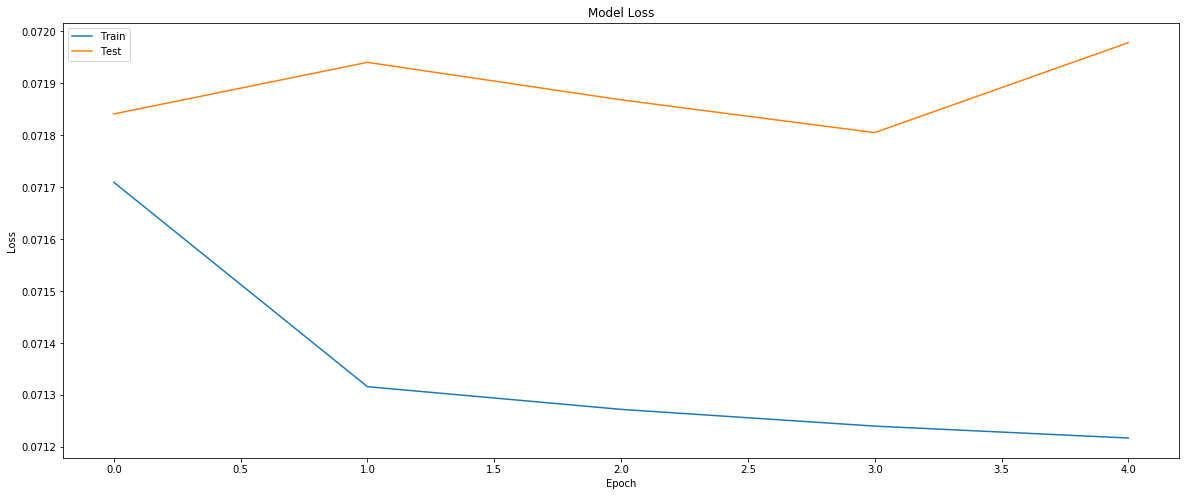

In [26]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(model_hist.history['loss'])
ax.plot(model_hist.history['val_loss'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Naive model- Vectorizer

In [27]:
def get_query(X):
  return pd.DataFrame(X,columns=['query','title'])['query'].values
def get_title(X):
  return pd.DataFrame(X,columns=['query','title'])['title'].values

Naive_X = []
Naive_Y = []
Naive_X_Test = []
Naive_Y_Test = []

for index,row in train.iterrows():
  Naive_Y.append(row['relevance'])
  Naive_X.append([''.join(list(row['search_term'])),''.join(list(row['product_title']))])

for index,row in test.iterrows():
  Naive_Y_Test.append(row['relevance'])
  Naive_X_Test.append([''.join(list(row['search_term'])),''.join(list(row['product_title']))])

pipeline = Pipeline(
    [
     ('fetures',
         FeatureUnion(
             [
                 ('later',
                  Pipeline(
                      [
                          ('query',FunctionTransformer(get_query)),
                          ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False,analyzer='char'))
                      ]
                  )),
                 ('bins',
                  Pipeline(
                      [
                       ('title',FunctionTransformer(get_title)),
                       ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False,analyzer='char'))
                      ]
                  )
                 )
             ]
         )
      ),
     ('clf', LinearRegression()),
    ]
)
naive_model = cross_validate(pipeline, Naive_X, Naive_Y, cv=5,
                             return_estimator=True,return_train_score=True,
                             scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
best_estimator = np.argmax(naive_model['test_neg_mean_squared_error'])
predictions = naive_model['estimator'][best_estimator].predict(Naive_X_Test)

mae = np.absolute((np.array(Naive_Y_Test)-np.array(predictions))).mean()
r_rmse = math.sqrt(((np.array(Naive_Y_Test)-np.array(predictions))**2).mean())

print("Train MAE: %.3f" %-naive_model['train_neg_mean_absolute_error'][best_estimator])
print("Train RMSE: %.3f" %-naive_model['train_neg_root_mean_squared_error'][best_estimator])
print("Validation MAE: %.3f" %-naive_model['test_neg_mean_absolute_error'][best_estimator])
print("Validation RMSE: %.3f" %-naive_model['test_neg_root_mean_squared_error'][best_estimator])
print("Test MAE: %.3f" %mae)
print("Test RMSE: %.3f" %r_rmse)

Train MAE: 0.433
Train RMSE: 0.529
Validation MAE: 0.438
Validation RMSE: 0.524
Test MAE: 0.437
Test RMSE: 0.533


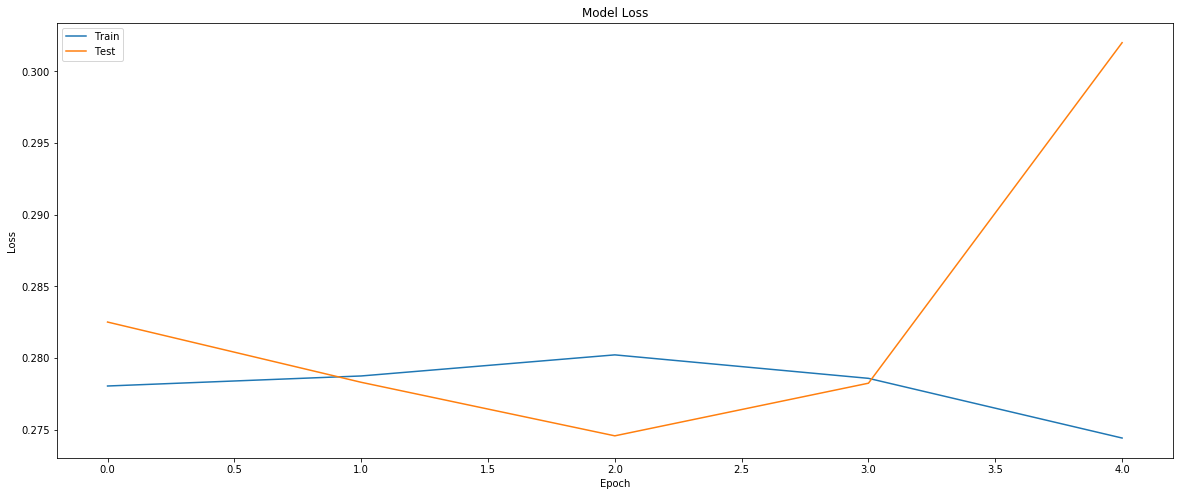

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-naive_model['train_neg_mean_squared_error'])
ax.plot(-naive_model['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Transfer Learning to classical ML

In [29]:
%%time

siames_model_ML = Model(siames_model.input,siames_model.layers[-2].output)
siames_model_ML.compile(loss='mse',optimizer='SGD')
siames_model_ML.summary()


ml_predictions_train = siames_model_ML.predict([X1,X2])
ml_predictions_test = siames_model_ML.predict([X1_RTest,X2_RTest])


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
inp2 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          535336      inp1[0][0]                       
                                                                 inp2[0][0]                       
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 256)          0           model_3[1][0]              

##XGBOOST

In [32]:
%%time
ml_xgboost_model = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10)
ml_xgboost_estimators = cross_validate(ml_xgboost_model, ml_predictions_train, np.array(Y)*2+1,cv=5,
                                   return_estimator=True,return_train_score=True,
                                   scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
best_estimator = np.argmax(ml_xgboost_estimators['test_neg_mean_squared_error'])
ml_xgoost_predictions = ml_xgboost_estimators['estimator'][best_estimator].predict(ml_predictions_test)

y_t=np.array(Y_RTest)*2+1
mae_xgboost = np.absolute((y_t-np.array(ml_xgoost_predictions))).mean()
rmse_xgboost = math.sqrt(((y_t-np.array(ml_xgoost_predictions))**2).mean())

print("XGBOOST Train MAE: %.3f" %-ml_xgboost_estimators['train_neg_mean_absolute_error'][best_estimator])
print("XGBOOST Train RMSE: %.3f" %-ml_xgboost_estimators['train_neg_root_mean_squared_error'][best_estimator])
print("XGBOOST Validation MAE: %.3f" %-ml_xgboost_estimators['test_neg_mean_absolute_error'][best_estimator])
print("XGBOOST Validation RMSE: %.3f" %-ml_xgboost_estimators['test_neg_root_mean_squared_error'][best_estimator])
print("XGBOOST Test MAE: %.3f" %mae_xgboost)
print("XGBOOST Test RMSE: %.3f" %rmse_xgboost)


[10:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST Train MAE: 0.434
XGBOOST Train RMSE: 0.534
XGBOOST Validation MAE: 0.442
XGBOOST Validation RMSE: 0.530
XGBOOST Test MAE: 0.438
XGBOOST Test RMSE: 0.533
CPU times: user 1min 28s, sys: 279 ms, total: 1min 28s
Wall time: 1min 28s


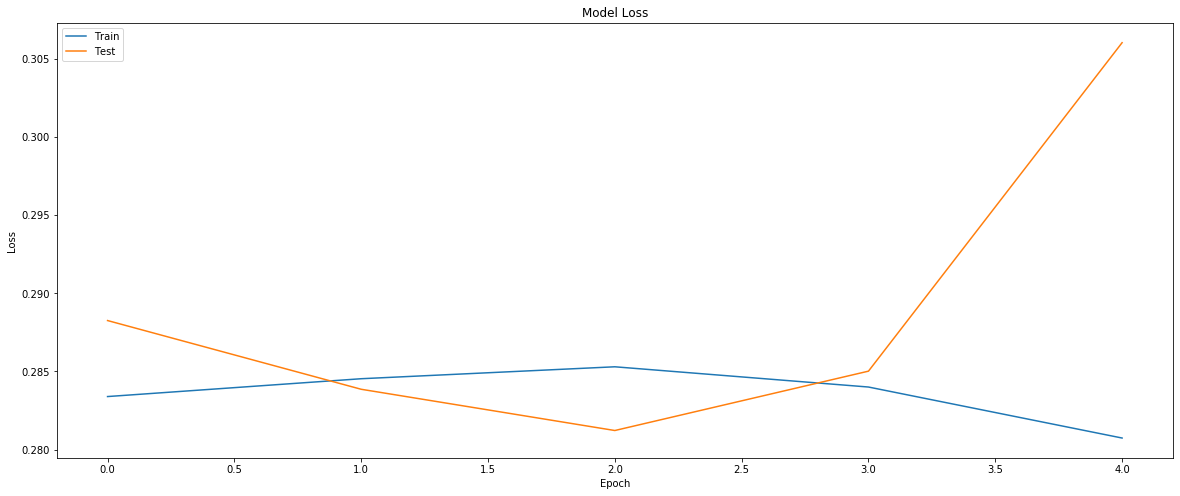

In [33]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_xgboost_estimators['train_neg_mean_squared_error'])
ax.plot(-ml_xgboost_estimators['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Random forest

In [34]:
%%time

ml_rf_model = RandomForestRegressor(n_jobs=16,min_samples_leaf=2, max_depth =3,n_estimators=5)
ml_rf_estimators = cross_validate(ml_rf_model, ml_predictions_train, np.array(Y)*2+1,
                                  cv=5,return_estimator=True,return_train_score=True,
                                  scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
best_estimator = np.argmax(ml_rf_estimators['test_neg_mean_squared_error'])
ml_rf_predictions = ml_rf_estimators['estimator'][best_estimator].predict(ml_predictions_test)

y_t_rf=np.array(Y_RTest)*2+1

mae_rf = np.absolute((np.array(y_t_rf)-np.array(ml_rf_predictions*2+1))).mean()
rmse_rf = math.sqrt(((np.array(y_t_rf)-np.array(ml_rf_predictions*2+1))**2).mean())

print("RANDOM Train MAE: %.3f" %-ml_rf_estimators['train_neg_mean_absolute_error'][best_estimator])
print("RANDOM Train RMSE: %.3f" %-ml_rf_estimators['train_neg_root_mean_squared_error'][best_estimator])
print("RANDOM Validation MAE: %.3f" %-ml_rf_estimators['test_neg_mean_absolute_error'][best_estimator])
print("RANDOM Validation RMSE: %.3f" %-ml_rf_estimators['test_neg_root_mean_squared_error'][best_estimator])
print("RANDOM MAE: %.3f" %mae_rf)
print("RANDOM RMSE: %.3f" %rmse_rf)

RANDOM Train MAE: 0.435
RANDOM Train RMSE: 0.535
RANDOM Validation MAE: 0.441
RANDOM Validation RMSE: 0.530
RANDOM MAE: 3.332
RANDOM RMSE: 3.375
CPU times: user 810 ms, sys: 3.32 s, total: 4.13 s
Wall time: 8.82 s


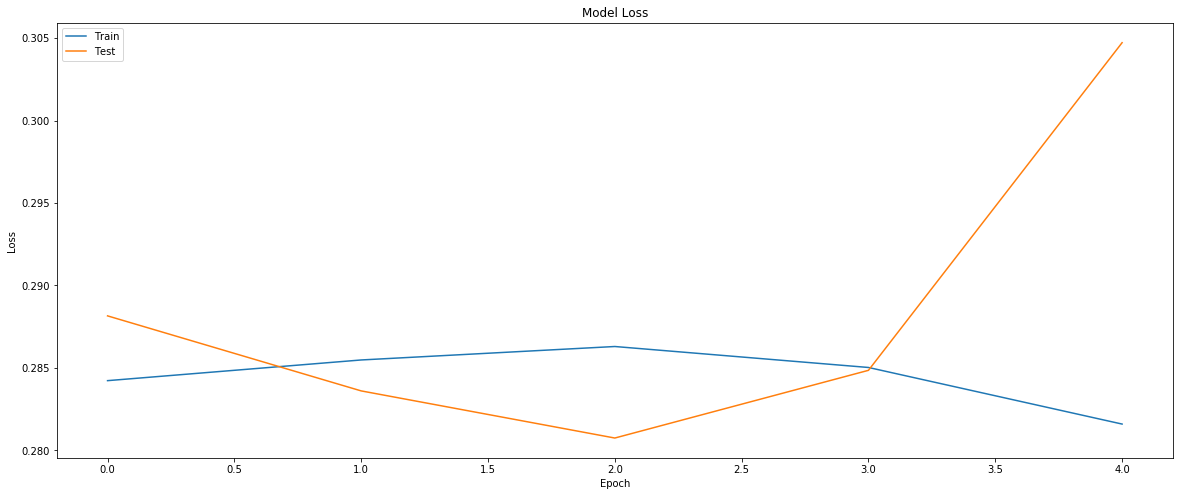

In [35]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_rf_estimators['train_neg_mean_squared_error'])
ax.plot(-ml_rf_estimators['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

We explored the data and decided we need to do some preprocessing

we found some examples for words that ment the same thing but were wrote differently.

for example in the 'product title' column there is no 'inches' there is 'in.'
but in the 'search term' there is 'inches'

In [36]:
 print ('\'product_titles\' contains \'inches\'')
 display(train.loc[train['product_title'].str.contains(' inches ')])
 print ('\n\n\n\'search_terms\' contains \'inches\'')
 display(train.loc[train['search_term'].str.contains(' inches ')].head(5))

'product_titles' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance





'search_terms' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
4015,12507,102193,Samsung 28.15 cu. ft. 4-Door French Door Refri...,33 inches wide samsung,2.67,0.835
13646,42206,110179,JELD-WEN Smooth 4-Panel Primed Molded Interior...,interior doors 82 inches in length,2.33,0.665
14917,46069,111389,Paslode 3 in. x 0.131-Gauge 30å¡ Brite Smooth ...,3 .5 inches paper tape collated,2.00,0.500
15609,48121,112069,Roberts Laminate Cutter for Cross Cutting up t...,metric to inches converter,1.67,0.335
17099,52792,113648,Masonite 30 in. x 80 in. Textured 6-Panel Holl...,interior doors 82 inches in length,2.67,0.835


In [0]:
import re
def preprocess_sentences(s):
  s = s.lower()
  s = re.sub(r"(\d+)'",r'\1in.',s)
  s = s.replace("inches","in.") 
  s = s.replace("inch","in.")
  s = s.replace(" in ","in. ") 
  s = s.replace(" in.","in.") 

  s = s.replace("''","ft.") 
  s = s.replace(" feet ","ft. ") 
  s = s.replace("feet","ft.") 
  s = s.replace("foot","ft.") 
  s = s.replace(" ft ","ft. ") 
  s = s.replace(" ft.","ft.") 

  s = s.replace(" pounds ","lb. ")
  s = s.replace(" pound ","lb. ") 
  s = s.replace("pound","lb.") 
  s = s.replace(" lb ","lb. ") 
  s = s.replace(" lb.","lb.") 
  s = s.replace(" lbs ","lb. ") 
  s = s.replace("lbs.","lb.") 

  s = s.replace(" x "," xby ")
  s = s.replace("*"," xby ")
  s = s.replace(" by "," xby")
  s = s.replace("x0"," xby 0")
  s = s.replace("x1"," xby 1")
  s = s.replace("x2"," xby 2")
  s = s.replace("x3"," xby 3")
  s = s.replace("x4"," xby 4")
  s = s.replace("x5"," xby 5")
  s = s.replace("x6"," xby 6")
  s = s.replace("x7"," xby 7")
  s = s.replace("x8"," xby 8")
  s = s.replace("x9"," xby 9")
  s = s.replace("0x","0 xby ")
  s = s.replace("1x","1 xby ")
  s = s.replace("2x","2 xby ")
  s = s.replace("3x","3 xby ")
  s = s.replace("4x","4 xby ")
  s = s.replace("5x","5 xby ")
  s = s.replace("6x","6 xby ")
  s = s.replace("7x","7 xby ")
  s = s.replace("8x","8 xby ")
  s = s.replace("9x","9 xby ")

  s = s.replace(" sq ft","sq.ft. ") 
  s = s.replace("sq ft","sq.ft. ")
  s = s.replace("sqft","sq.ft. ")
  s = s.replace(" sqft ","sq.ft. ") 
  s = s.replace("sq. ft","sq.ft. ") 
  s = s.replace("sq ft.","sq.ft. ") 
  s = s.replace("sq feet","sq.ft. ") 
  s = s.replace("square feet","sq.ft. ") 

  s = s.replace(" gallons ","gal. ") 
  s = s.replace(" gallon ","gal. ") 
  s = s.replace("gallons","gal.") 
  s = s.replace("gallon","gal.") 
  s = s.replace(" gal ","gal. ") 
  s = s.replace(" gal","gal.") 

  s = s.replace("ounces","oz.")
  s = s.replace("ounce","oz.")
  s = s.replace(" oz.","oz. ")
  s = s.replace(" oz ","oz. ")

  s = s.replace("centimeters","cm.")    
  s = s.replace(" cm.","cm.")
  s = s.replace(" cm ","cm. ")
  
  s = s.replace("milimeters","mm.")
  s = s.replace(" mm.","mm.")
  s = s.replace(" mm ","mm. ")
  
  s = s.replace("°","deg. ")
  s = s.replace("degrees","deg. ")
  s = s.replace("degree","deg. ")
  
  s = s.replace("volts","volt. ")
  s = s.replace("volt","volt. ")

  s = s.replace("watts","watt. ")
  s = s.replace("watt","watt. ")

  return s

In [38]:
processed_train = train.copy()
processed_train['search_term'] = processed_train['search_term'].map(lambda x:preprocess_sentences(x))
processed_train['product_title'] = processed_train['product_title'].map(lambda x:preprocess_sentences(x))

print ('\'product_titles\' contains \'inches\'')
display(processed_train.loc[processed_train['product_title'].str.contains(' in. ')])
print ('\n\n\n\'search_terms\' contains \'inches\'')
display(processed_train.loc[processed_train['search_term'].str.contains(' in. ')].head(5))

'product_titles' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
18498,57112,115108,ready-strip 32oz. environmentally friendly dr...,adhesive slide strip,1.67,0.335
25119,77115,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,12in. ceiling tile,2.00,0.500
25120,77121,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,sound dampening,2.67,0.835
25121,77123,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,sounds panels,2.00,0.500
67581,202995,191353,mohawk home ink swirl cocoa 2ft. xby 8ft. runner,rug ruunners,2.00,0.500





'search_terms' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
42161,128340,144629,liberty 20in. european self-closing drawer sli...,18.75 in. drawer slides,2.67,0.835
54368,164835,164764,kaleen matira blue 2ft. xby 3ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",2.00,0.500
55418,167918,166665,kaleen matira blue 2ft. xby 3ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",3.00,1.000
60397,182300,176124,kaleen matira blue 3ft. xby 5ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",3.00,1.000


In [0]:
processed_test = test.copy()
processed_test['search_term'] = processed_test['search_term'].map(lambda x:preprocess_sentences(x))
processed_test['product_title'] = processed_test['product_title'].map(lambda x:preprocess_sentences(x))

##Word level LSTM

In [0]:
max_product_title_len=processed_train.product_title.map(lambda x: len(x.split(' '))).max()
max_search_term=processed_train.search_term.map(lambda x: len(x.split(' '))).max()
max_input_len=max(max_product_title_len,max_search_term,70)

In [0]:
myGen=MyWordGenerator(padding=max_input_len,df=processed_train,batch_size=1)
it = iter(myGen)

X1 = []
X2 = []
Y = []
for time in range(len(processed_train)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1.append([X for X in X1_gen[0]])
  X2.append([X for X in X2_gen[0]])
  Y.append(y_gen[0])

X1_RTest = []
X2_RTest = []
Y_RTest = []

for time in range(len(processed_test)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1_RTest.append([X for X in X1_gen[0]])
  X2_RTest.append([X for X in X2_gen[0]])
  Y_RTest.append(y_gen[0])

X1_train,X1_test,X2_train,X2_test,y_train,y_test = train_test_split(X1,X2,Y,test_size=0.2)

X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
y_train = np.array(y_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
y_test = np.array(y_test)


##Embedding Training

In [44]:
%%time

def embedding_input(name, n_in, n_out, reg=1e-4):
    inp = Input(shape=(70,1), dtype='int64', name=name)
    x = Flatten()(inp)
    return inp, Embedding(n_in, n_out, input_length=70, embeddings_regularizer=l2(reg))(x)

query_inp,query_emb = embedding_input("query",len(processed_train.search_term.unique()),50)
title_inp,title_emb = embedding_input("title",len(processed_train.product_title.unique()),50)
x = Concatenate()([query_emb,title_emb])
x = Flatten()(x)
x= BatchNormalization()(x)
# x= Activation('relu')(x)
x = Dense(1,activation='relu')(x)
embedding_model = Model([query_inp, title_inp], x)
embedding_model.compile(optimizer='adam', loss='mae',metrics=['accuracy',rmse,'mae'])
embedding_model.summary()


embedding_model_hist = embedding_model.fit([X1_train,X2_train], y_train, batch_size=20, epochs=10, 
          validation_data=([X1_test,X2_test], y_test))

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 70)           0           title[0][0]                      
____________________________________________________________________________________________

## Siamese word LSTM

In [45]:
inp=Input(shape=(70,50))
x = CuDNNLSTM(70)(inp)
x = Reshape((70,1))(x)
x=Conv1D(filters=32,kernel_size=10,activation='relu')(x)
x=MaxPool1D()(x)
x=BatchNormalization()(x)
x=Activation('tanh')(x)
x=Conv1D(filters=64,kernel_size=10,activation='relu')(x)
x=MaxPool1D()(x)
x=Conv1D(filters=128,kernel_size=10,activation='relu')(x)
x=BatchNormalization()(x)
x=Activation('tanh')(x)
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
model= Model(inp,x)

search_term_encoded=model(query_emb)
product_title_encoded=model(title_emb)


x_connected=Concatenate()([search_term_encoded,product_title_encoded])
x_connected=Dense(1,activation='sigmoid')(x_connected)

siames_embedded_model = Model([query_inp,title_inp],x_connected)
siames_embedded_model.summary()
siames_embedded_model.compile(loss=our_mse ,optimizer='adam',metrics=['mae','accuracy',rmse])

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 70)           0           title[0][0]                      
____________________________________________________________________________________________

In [46]:
%%time
word_model_hist = siames_embedded_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=5,batch_size=32,validation_data=([X1_test,X2_test],y_test))

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
 - 47s - loss: 0.0723 - mean_absolute_error: 0.2196 - acc: 0.2585 - rmse: 0.2196 - val_loss: 0.0772 - val_mean_absolute_error: 0.2239 - val_acc: 0.2568 - val_rmse: 0.2239
Epoch 2/5
 - 45s - loss: 0.0724 - mean_absolute_error: 0.2155 - acc: 0.2586 - rmse: 0.2155 - val_loss: 0.0911 - val_mean_absolute_error: 0.2268 - val_acc: 0.2568 - val_rmse: 0.2268
Epoch 3/5
 - 45s - loss: 0.0681 - mean_absolute_error: 0.2027 - acc: 0.2592 - rmse: 0.2027 - val_loss: 0.1117 - val_mean_absolute_error: 0.2503 - val_acc: 0.2568 - val_rmse: 0.2503
Epoch 4/5
 - 46s - loss: 0.0635 - mean_absolute_error: 0.1944 - acc: 0.2627 - rmse: 0.1944 - val_loss: 0.0779 - val_mean_absolute_error: 0.2196 - val_acc: 0.2568 - val_rmse: 0.2196
Epoch 5/5
 - 45s - loss: 0.0620 - mean_absolute_error: 0.1906 - acc: 0.2654 - rmse: 0.1906 - val_loss: 0.0779 - val_mean_absolute_error: 0.2187 - val_acc: 0.2568 - val_rmse: 0.2187
CPU times: user 5min 6s, sys: 40.6 s, total: 

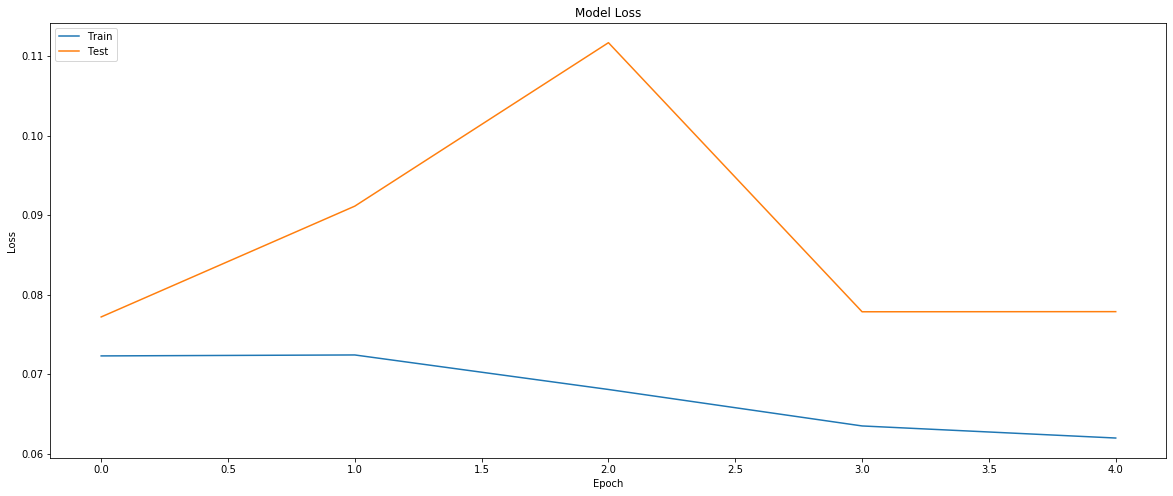

In [47]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(word_model_hist.history['loss'])
ax.plot(word_model_hist.history['val_loss'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

## Naive Model- vectorize

In [48]:
def get_query(X):
  return pd.DataFrame(X,columns=['query','title'])['query'].values
def get_title(X):
  return pd.DataFrame(X,columns=['query','title'])['title'].values

Naive_X = []
Naive_Y = []
Naive_X_Test = []
Naive_Y_Test = []

for index,row in processed_train.iterrows():
  Naive_Y.append(row['relevance'])
  Naive_X.append([row['search_term'],row['product_title']])

for index,row in processed_test.iterrows():
  Naive_Y_Test.append(row['relevance'])
  Naive_X_Test.append([row['search_term'],row['product_title']])

pipeline = Pipeline(
    [
     ('fetures',
         FeatureUnion(
             [
                 ('later',
                  Pipeline(
                      [
                          ('query',FunctionTransformer(get_query)),
                          ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False))
                      ]
                  )),
                 ('bins',
                  Pipeline(
                      [
                       ('title',FunctionTransformer(get_title)),
                       ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False))
                      ]
                  )
                 )
             ]
         )
      ),
     ('clf', LinearRegression()),
    ]
)


naive_word_model = cross_validate(pipeline, Naive_X ,Naive_Y, cv=5,
                                  return_estimator=True,return_train_score=True,
                                  scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
word_best_estimator = np.argmax(naive_word_model['test_neg_mean_squared_error'])
predictions = naive_word_model['estimator'][word_best_estimator].predict(Naive_X_Test)

mae = np.absolute((np.array(Naive_Y_Test)-np.array(predictions))).mean()
r_rmse = math.sqrt(((np.array(Naive_Y_Test)-np.array(predictions))**2).mean())

print("Train MAE: %.3f" %-naive_model['train_neg_mean_absolute_error'][word_best_estimator])
print("Train RMSE: %.3f" %-naive_model['train_neg_root_mean_squared_error'][word_best_estimator])
print("Validation MAE: %.3f" %-naive_model['test_neg_mean_absolute_error'][word_best_estimator])
print("Validation RMSE: %.3f" %-naive_model['test_neg_root_mean_squared_error'][word_best_estimator])
print("Test MAE: %.3f" %mae)
print("Test RMSE: %.3f" %r_rmse)


Train MAE: 0.433
Train RMSE: 0.529
Validation MAE: 0.438
Validation RMSE: 0.524
Test MAE: 0.462
Test RMSE: 0.578


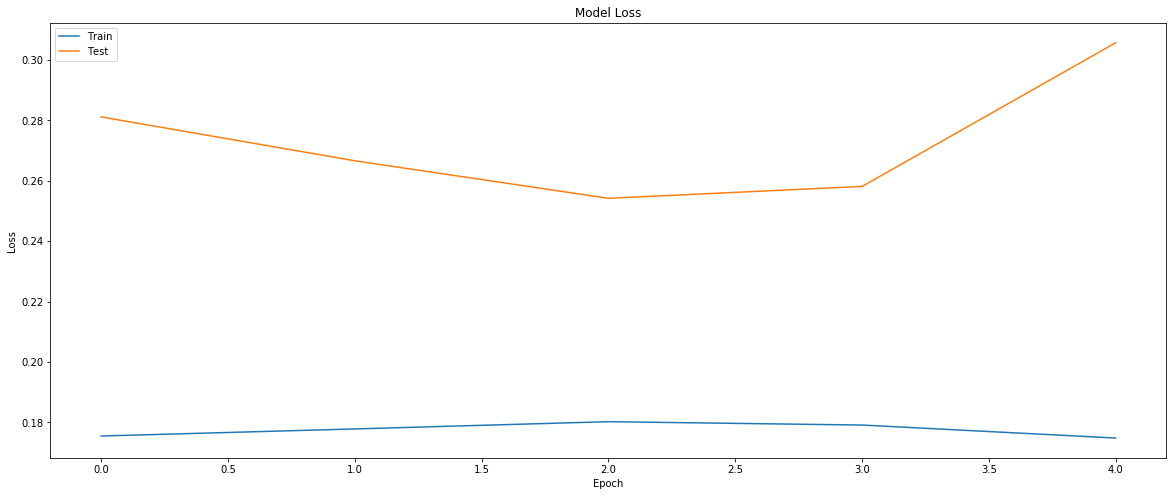

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-naive_word_model['train_neg_mean_squared_error'])
ax.plot(-naive_word_model['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Transfer Learning to classical ML


In [50]:

siames_word_model_ML = Model(siames_embedded_model.input,siames_embedded_model.layers[-2].output)
siames_word_model_ML.compile(optimizer='SGD')
siames_word_model_ML.summary()


word_ml_predictions_train = siames_word_model_ML.predict([X1,X2])
word_ml_predictions_test = siames_word_model_ML.predict([X1_RTest,X2_RTest])


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 70)           0           title[0][0]                      
___________________________________________________________________________________________

##XGBOOST



In [52]:
%%time

ml_xgboost_word_model = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10)
ml_xgboost_word_estimators = cross_validate(ml_xgboost_word_model, word_ml_predictions_train, np.array(Y)*2+1,
                                        cv=5,return_estimator=True,return_train_score=True,
                                        scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
best_estimator = np.argmax(ml_xgboost_word_estimators['test_neg_mean_squared_error'])
word_ml_xgboost_predictions = ml_xgboost_word_estimators['estimator'][best_estimator].predict(word_ml_predictions_test)

y_t=np.array(Y_RTest)*2+1

word_mae_xgboost = np.absolute((y_t-np.array(word_ml_xgboost_predictions))).mean()
word_rmse_xgboost = math.sqrt(((y_t-np.array(word_ml_xgboost_predictions))**2).mean())


print("XGBOOST Train MAE: %.3f" %-ml_xgboost_word_estimators['train_neg_mean_absolute_error'][best_estimator])
print("XGBOOST Train RMSE: %.3f" %-ml_xgboost_word_estimators['train_neg_root_mean_squared_error'][best_estimator])
print("XGBOOST Validation MAE: %.3f" %-ml_xgboost_word_estimators['test_neg_mean_absolute_error'][best_estimator])
print("XGBOOST Validation RMSE: %.3f" %-ml_xgboost_word_estimators['test_neg_root_mean_squared_error'][best_estimator])
print("XGBOOST Test MAE: %.3f" %word_mae_xgboost)
print("XGBOOST Test RMSE: %.3f" %word_rmse_xgboost)



[10:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST Train MAE: 0.362
XGBOOST Train RMSE: 0.452
XGBOOST Validation MAE: 0.358
XGBOOST Validation RMSE: 0.444
XGBOOST Test MAE: 0.362
XGBOOST Test RMSE: 0.451
CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


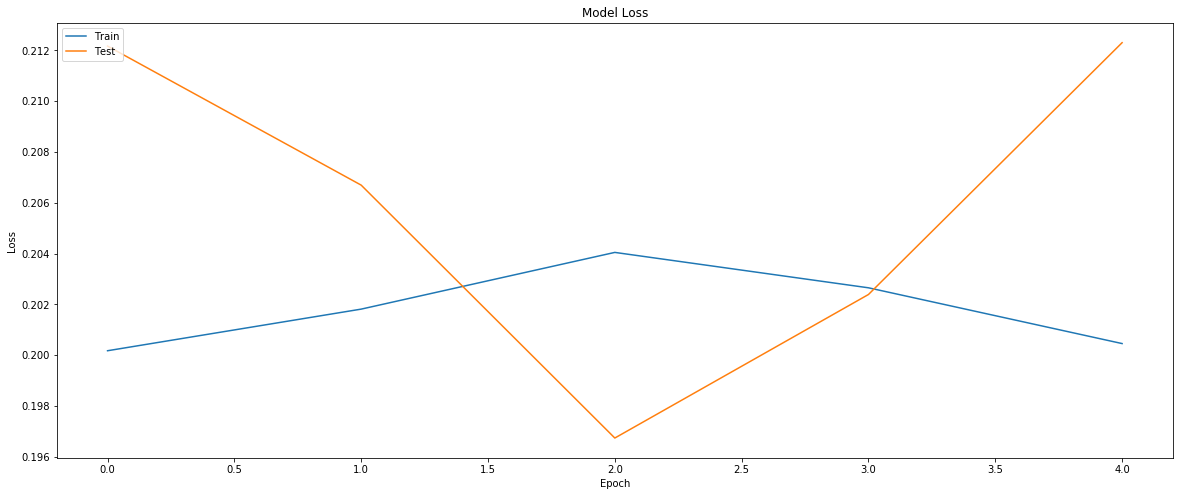

In [53]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_xgboost_word_estimators['train_neg_mean_squared_error'])
ax.plot(-ml_xgboost_word_estimators['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Random forest

In [55]:
%%time

ml_rf_word_model = RandomForestRegressor(n_jobs=16,min_samples_leaf=2, max_depth =3,n_estimators=5)
ml_rf_word_estimators = cross_validate(ml_rf_word_model, word_ml_predictions_train, np.array(Y)*2+1,
                                       cv=5,return_estimator=True,return_train_score=True,
                                       scoring=['neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'])
best_estimator = np.argmax(ml_rf_word_estimators['test_neg_mean_squared_error'])
word_ml_rf_predictions = ml_rf_word_estimators['estimator'][best_estimator].predict(word_ml_predictions_test)

y_t_rf=np.array(Y_RTest)*2+1

word_mae_rf = np.absolute((y_t_rf-np.array(word_ml_rf_predictions*2+1))).mean()
word_rmse_rf = math.sqrt(((y_t_rf-np.array(word_ml_rf_predictions*2+1))**2).mean())

print("RANDOM Train MAE: %.3f" %-ml_rf_word_estimators['train_neg_mean_absolute_error'][best_estimator])
print("RANDOM Train RMSE: %.3f" %-ml_rf_word_estimators['train_neg_root_mean_squared_error'][best_estimator])
print("RANDOM Validation MAE: %.3f" %-ml_rf_word_estimators['test_neg_mean_absolute_error'][best_estimator])
print("RANDOM Validation RMSE: %.3f" %-ml_rf_word_estimators['test_neg_root_mean_squared_error'][best_estimator])
print("RANDOM MAE: %.3f" %word_mae_rf)
print("RANDOM RMSE: %.3f" %word_rmse_rf)


RANDOM Train MAE: 0.383
RANDOM Train RMSE: 0.475
RANDOM Validation MAE: 0.376
RANDOM Validation RMSE: 0.464
RANDOM MAE: 3.374
RANDOM RMSE: 3.416
CPU times: user 834 ms, sys: 163 ms, total: 997 ms
Wall time: 7.79 s


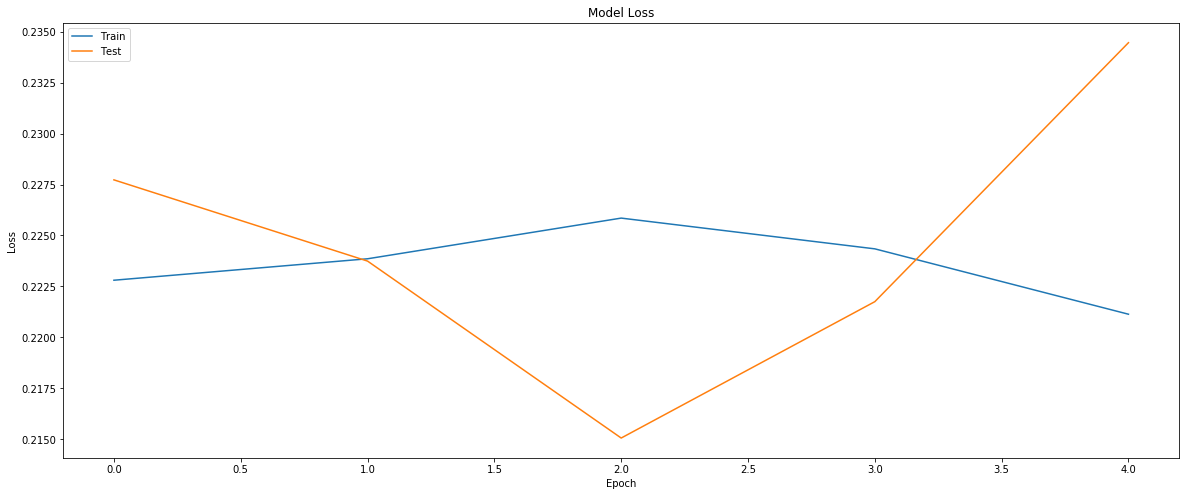

In [56]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_rf_word_estimators['train_neg_mean_squared_error'])
ax.plot(-ml_rf_word_estimators['test_neg_mean_squared_error'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')